# CAICT 風機結冰預測 - RNN

2017/07/12  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

# **1. Load Data and Modules**

**Load Python modules:**

In [189]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import csv
import sklearn as sk
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers import Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D

from keras.models import Sequential
from sklearn.metrics import roc_curve, auc 
from sklearn import preprocessing

import keras.backend as K
import numpy as np
import random
import sys
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence


import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "last"

In [2]:
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    #print('tn:',tn,'fp:',fp,'fn:',fn,'fp:',fp)
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    #print('score',score)
    return score, {'tn':tn,'fp':fp,'fn':fn,'tp':tp}


In [3]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled



##------------------------

def load_resample_data(mid, policy=1,  ycol='power', fillna=0):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(fillna)
    data_resample[data_resample['label']==2]=0
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    #data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    non_data_cols = ['label','time','group','timestamp','event']
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_resample[col]
    return data_resample,data_scaled

##------------------------

def load_test2_data():
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group','generator_speed'], axis=1)
    test_X = tmp.values
    return test_X, test_timeidx

    

In [4]:
def rnn_dataset(data, n_steps):
    dataset_new = []
    for idx, _ in enumerate(data):
        start_idx = idx-n_steps
        end_idx = idx+1
        if start_idx<0:
            continue
        n=np.concatenate(data[start_idx:end_idx], axis=0)
        dataset_new.append(n)
    dataset_new = np.asarray(dataset_new)
    return dataset_new

In [5]:
def rnn_dataset(data, n_steps):
    dataset_new = []
    for idx, _ in enumerate(data):
        start_idx = idx-n_steps
        end_idx = idx
        if start_idx<0:
            continue
        n=np.concatenate(data[start_idx:end_idx], axis=0)
        dataset_new.append(n)
    dataset_new = np.asarray(dataset_new)
    return dataset_new
    

**Load input data.** 

In [6]:
xcols=['wind_speed', 'wind_direction',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']


In [7]:
_, data_scaled_M15 = load_resample_data(mid=15,policy=4)

data_M15_train = data_scaled_M15[data_scaled_M15['event']<20]
data_M15_valid = data_scaled_M15[data_scaled_M15['event']>=20]

ycol='label'
data_M15_train_X = data_M15_train[xcols]
data_M15_train_y = data_M15_train[ycol]
data_M15_train_Y = np.eye(data_M15_train_y.unique().size)[data_M15_train_y.values.astype(int)]

data_M15_valid_X = data_M15_valid[xcols]
data_M15_valid_y = data_M15_valid[ycol]
data_M15_valid_Y = np.eye(data_M15_valid_y.unique().size)[data_M15_valid_y.values.astype(int)]

data_M15_test_X = data_scaled_M15[xcols]
data_M15_test_y = data_scaled_M15[ycol]
data_M15_test_Y = np.eye(data_M15_test_y.unique().size)[data_M15_test_y.values.astype(int)]

_, data_scaled_M21 = load_resample_data(mid=21,policy=0)
data_M21_test_X = data_scaled_M21[xcols]
data_M21_test_y = data_scaled_M21[ycol]
data_M21_test_Y = np.eye(data_M21_test_y.unique().size)[data_M21_test_y.values.astype(int)]


#_, data_X_M21, data_Y_M21, data_y_M21  = load_training_data(mid=21,policy=0)

#_, data_X_M21, data_Y_M21, data_y_M21  = load_training_data(mid=21,policy=0)
#test_X,test_timeidx = load_test2_data()

load file: data/resample_data_p4_15.csv
load file: data/resample_data_p0_21.csv


** 為了RNN需求, 更改X format **

In [8]:
n_steps = 50
data_M15_train_X_new = rnn_dataset(data_M15_train_X.values,n_steps)
data_M15_valid_X_new = rnn_dataset(data_M15_valid_X.values,n_steps)
data_M21_test_X_new = rnn_dataset(data_M21_test_X.values,n_steps)
data_M15_test_X_new = rnn_dataset(data_M15_test_X.values,n_steps)
#test_X = rnn_dataset(test_X,n_steps_)

data_M15_train_X_new = data_M15_train_X_new.reshape([-1, n_steps, len(xcols)])
data_M15_valid_X_new = data_M15_valid_X_new.reshape([-1, n_steps, len(xcols)])
data_M21_test_X_new = data_M21_test_X_new.reshape([-1, n_steps, len(xcols)])
data_M15_test_X_new = data_M15_test_X_new.reshape([-1, n_steps, len(xcols)])
#test_X = test_X.reshape([-1, 50, len(xcols)])

In [9]:
data_M15_train_Y_new=data_M15_train_Y[n_steps:]
data_M15_train_y_new=data_M15_train_y[n_steps:]
data_M15_valid_Y_new=data_M15_valid_Y[n_steps:]
data_M15_valid_y_new=data_M15_valid_y[n_steps:]
data_M21_test_Y_new=data_M21_test_Y[n_steps:]
data_M21_test_y_new=data_M21_test_y[n_steps:]
data_M15_test_Y_new=data_M15_test_Y[n_steps:]
data_M15_test_y_new=data_M15_test_y[n_steps:]
#test_timeidx_new=test_timeidx[n_steps_:]

** RNN netwrok structure **  


tips:  
- output 2 個class時, activation用softmax, output一個value時, activation function用sigmoid
- output 2 個class時, label data用xxx_Y, output一個value時, label data用xxx_y



In [265]:
def basic_GRU():
    model = Sequential()
    model.add(GRU(512, input_shape=(n_steps, len(xcols)),dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model
    

def basic_LSTM():
    model = Sequential()
    model.add(LSTM(512, input_shape=(n_steps, len(xcols)),dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

def multilayer_LSTM():
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_steps, len(xcols)), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(100,return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model

def bidirectional_LSTM():
    model = Sequential()
    model.add(Bidirectional( LSTM(128),input_shape=(n_steps, len(xcols)) ))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = RMSprop(lr=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model

def conv_LSTM():
    pass

def stateful_LSTM():
    pass


def basic_CNN():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     padding='same',
                     activation='relu',
                     input_shape=(n_steps, len(xcols),1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

def stateful_LSTM():
    model = Sequential()
    model.add(LSTM(50, input_shape=(n_steps, len(xcols)), return_sequences=True,stateful=True, batch_size=500))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(100,return_sequences=False,stateful=True, batch_size=500))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    optimizer = Adam(lr=0.001)
    model.compile(loss="binary_crossentropy", optimizer=optimizer)
    return model    

def CNN_LSTM():
    model = Sequential()
    model.add(Conv1D(32,
                     4,
                     padding='same',
                     activation='relu',
                     strides=1,input_shape=(n_steps, len(xcols))),
                     )
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    model.add(Conv1D(64,
                 4,
                 padding='same',
                 activation='relu',
                 strides=1,input_shape=(n_steps, len(xcols))),
                 )
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.15))
    model.add(BatchNormalization())
    model.add(LSTM(320))
    model.add(Dropout(0.15))
    model.add(Activation('sigmoid'))
    model.add(Dense(100))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam')
    return model

In [266]:
model= CNN_LSTM()
#model = basic_CNN()

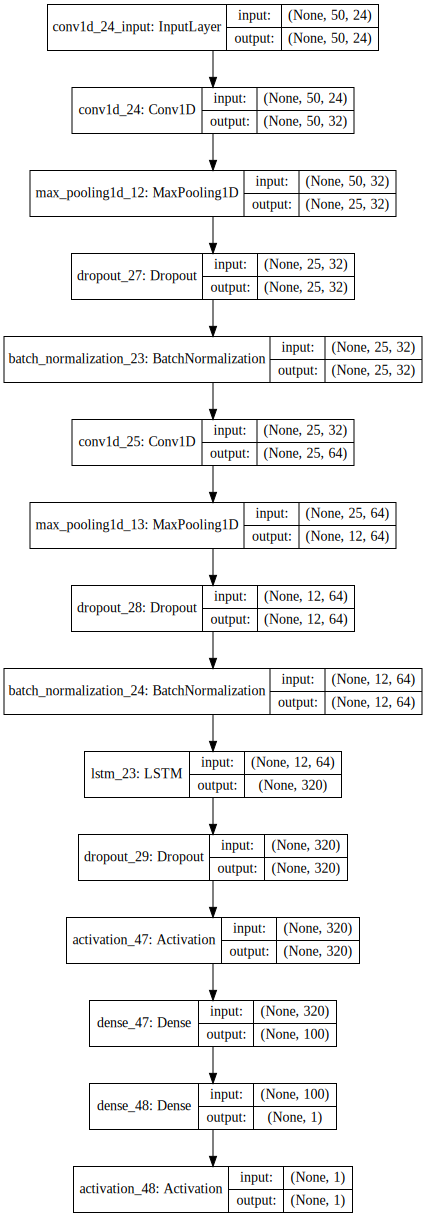

In [267]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [268]:
class_weight = {0 : 3., 1: 1.}

history = model.fit(data_M15_train_X_new[:78000], data_M15_train_y_new[:78000], epochs=10, batch_size=500, class_weight = class_weight)

#x_train_cnn_format = data_M15_train_X_new.reshape(data_M15_train_X_new.shape[0], 50, 24, 1)
#history = model.fit(x_train_cnn_format, data_M15_train_y_new, validation_split=0.1, epochs=20, batch_size=500, class_weight = class_weight)

#model1.fit(data_M15_train_X_new, data_M15_train_y_new, batch_size=500, epochs=20,class_weight = class_weight)
#model1.fit(data_M15_train_X_new, data_M15_train_y_new, batch_size=500, epochs=5)


Epoch 1/10
78000/78000 [==============================] - 8s - loss: 0.5306     
Epoch 2/10
78000/78000 [==============================] - 7s - loss: 0.2529     
Epoch 3/10
78000/78000 [==============================] - 7s - loss: 0.1153     
Epoch 4/10
78000/78000 [==============================] - 7s - loss: 0.0707     
Epoch 5/10
78000/78000 [==============================] - 7s - loss: 0.0422     
Epoch 6/10
78000/78000 [==============================] - 7s - loss: 0.0393     
Epoch 7/10
78000/78000 [==============================] - 7s - loss: 0.0308     
Epoch 8/10
78000/78000 [==============================] - 7s - loss: 0.0292     
Epoch 9/10
78000/78000 [==============================] - 7s - loss: 0.0260     
Epoch 10/10
78000/78000 [==============================] - 7s - loss: 0.0220     


dict_keys(['loss'])


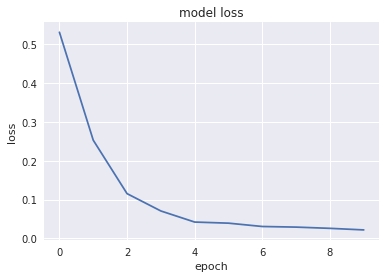

KeyError: 'val_loss'

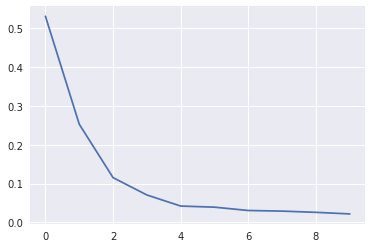

In [269]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

** 4. 預測與準確率評估  Evaluation **

In [274]:
threshold=0.9

In [270]:
#x_test = data_M15_train_X_new.reshape(data_M15_train_X_new.shape[0], 50, 24, 1)
#ret = model.predict(x_test)

#ret = model.predict(data_M15_train_X_new[:78000],batch_size=500)
ret = model.predict(data_M15_train_X_new)
pred_t = pd.DataFrame(ret)
pred_t_raw = pred_t.copy()
#pred_t = pred_t.apply(np.argmax,axis=1)

pred_t[pred_t >threshold] = 1
pred_t[pred_t <=threshold] = 0
pred_t[0].value_counts()

pd.Series(data_M15_train_y_new).value_counts()

print("Precision", precision_score(data_M15_train_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M15_train_y_new, pred_t))

s,_=myscore(data_M15_train_y_new, pred_t)
print('score',s,_)

Precision 0.994049852586
Recall 0.783405855266
score 0.890687095291 {'tn': 54524, 'fp': 111, 'fn': 5127, 'tp': 18544}


In [275]:
#x_test = data_M15_valid_X_new.reshape(data_M15_valid_X_new.shape[0], 50, 24, 1)
#ret = model.predict(x_test)

ret = model.predict(data_M15_valid_X_new)
pred_t = pd.DataFrame(ret)
pred_t_raw = pred_t.copy()
#pred_t = pred_t.apply(np.argmax,axis=1)
print(threshold)
pred_t[pred_t >threshold] = 1
pred_t[pred_t <=threshold] = 0
pred_t[0].value_counts()
pd.Series(data_M15_valid_y_new).value_counts()

print("Precision", precision_score(data_M15_valid_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M15_valid_y_new, pred_t))

s,_=myscore(data_M15_valid_y_new, pred_t)
print('score',s,_)

0.9
Precision 0.372933745464
Recall 0.643851508121
score 0.550172696402 {'tn': 3919, 'fp': 4666, 'fn': 1535, 'tp': 2775}


In [228]:
ret = model.predict(data_M21_test_X_new)
pred_t = pd.DataFrame(ret)
pred_t_raw = pred_t.copy()
#pred_t = pred_t.apply(np.argmax,axis=1)
pd.Series(data_M21_test_y_new).value_counts()

pred_t[pred_t >threshold] = 1
pred_t[pred_t <=threshold] = 0
pred_t[0].value_counts()

print("Precision", precision_score(data_M21_test_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M21_test_y_new, pred_t))

s,_=myscore(data_M21_test_y_new, pred_t)
print('score',s,_)

Precision 0.067734327056
Recall 0.861158112427
score 0.579956718805 {'tn': 53718, 'fp': 126088, 'fn': 1477, 'tp': 9161}


In [229]:
ret = model.predict(data_M15_test_X_new)
pred_t = pd.DataFrame(ret)
#pred_t = pred_t.apply(np.argmax,axis=1)
pred_t_raw = pred_t.copy()
pd.Series(data_M15_test_y_new).value_counts()
pred_t[pred_t >threshold] = 1
pred_t[pred_t <=threshold] = 0
pred_t[0].value_counts()
print("Precision", precision_score(data_M15_test_y_new, pred_t))
print("Recall", sk.metrics.recall_score(data_M15_test_y_new, pred_t))

s,_=myscore(data_M15_test_y_new, pred_t)
print('score',s,_)


Precision 0.769984051929
Recall 0.983524534506
score 0.926794668075 {'tn': 55049, 'fp': 8221, 'fn': 461, 'tp': 27520}


AUC: 0.507346488709


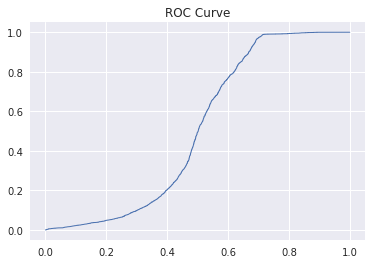

In [278]:
fpr, tpr, thresholds = roc_curve(data_M15_valid_y_new, pred_t_raw)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1) 
plt.title('ROC Curve')
print('AUC:',roc_auc)
plt.show()
roc_df = pd.DataFrame({'thresholds':thresholds, 'fpr':fpr,'tpr':tpr})
roc_df = roc_df[roc_df['tpr']>0.8][:10]

/home/bigdata/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


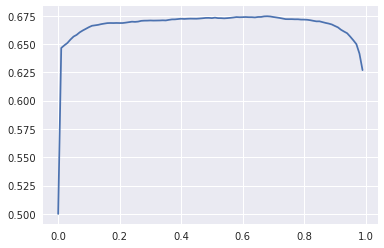

best_x: 0.68
best_score: 0.674510563292


In [48]:
x_tmp = np.arange(0., 1, 0.01)
y_tmp=[]
for threshold in x_tmp:
    pred_prob_tmp = pred_t_raw.copy()
    pred_prob_tmp[pred_prob_tmp >threshold] = 1
    pred_prob_tmp[pred_prob_tmp <=threshold] = 0
    s,_=myscore(data_M21_test_y_new, pred_prob_tmp)
    y_tmp.append(s)
    del pred_prob_tmp

plt.plot(x_tmp, y_tmp) 
plt.show()
best_idx = np.argmax(y_tmp)
best_x = x_tmp[best_idx]
best_y = y_tmp[best_idx]
print('best_x:',best_x)
print('best_score:',best_y)

In [ ]:
pred_T2 = pd.DataFrame(ret)
pred_T2 = pred_T2.apply(np.argmax,axis=1)
a = np.array([0]*n_steps_)
pred_test_y = np.concatenate([a, pred_T2.values])
data_scaled_M21['label_pred'] = pred_test_y

In [ ]:
data_scaled_M21['label_pred'].value_counts()
data_scaled_M21['label'].value_counts()

r2_baseline=0.9
events = data_scaled_M21['event'].unique()
x='wind_speed'
y='power'

for e in events:
    data_evt= data_scaled_M21[data_scaled_M21['event']==e]
    #data_unknown_evt = data_unknown[data_unknown['event']==e]
    dummy = plt.figure(figsize=[17,2])
    plt.plot(data_evt['label'],  color = 'blue', lw=0.5, label='this event')
    plt.plot(data_evt['label_pred'],  color = 'green', lw=0.5, label='this event')

    

***
#### Predict Test Data

## 5. 整理預測結果, 正確上傳格式

In [ ]:
pred_T.shape

In [ ]:
startTime=0
endTIme=0
search_start=True
search_end=False
abnormal_list=[]
shift = test_timeidx_new.index[0]
for i,v in enumerate(pred_T):
    i=i+shift
    if (v==1) & (search_start):
        startTime = test_timeidx_new[i]
        search_end=True
        search_start=False
    if (v==0) & (search_end):
        endTIme=test_timeidx_new[i]
        search_start=True
        search_end=False
        abnormal_list.append((startTime,test_timeidx_new[i-1]))
len(abnormal_list)

In [ ]:
output_ans=True
if(output_ans):
    with open('test1_08_results.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['startTime','endTime'])
        for row in abnormal_list:
            dummy = csv_out.writerow(row)

print('done')


In [ ]:
abnormal_list[:4]

## 6. Issue
1. Data Imbalance
 - training batch sample 一半normal一半abnormal的data
 - 用兩台風機訓練兩個model, 取故障預測的聯集 

2. 用Precision & Recall評估好壞, 算出Score


other:
- using weighted examples. Just amplify the per-instance loss by a larger weight when seeing positive examples. If you use online gradient descent, it can be as simple as using a larger learning rate when seeing positive examples.
- A similar and slightly better approach (only if you use stochastic gradient descent) is randomly picking an example in each iteration, where the positive examples have higher probability of being picked.

提交结果历史记录  
参赛队伍:　556 / 参赛人数:　858  
 
|竞赛阶段	 |上传者	 |分数	 |提交日期	 |排名	 |下载|
| ---------| -------- | ------ | ------ | ------ | ------ |
|初赛test1阶段|	孔祥千	|55.28684214|	2017/7/12|	50	|下载|

Note: 7/13
1. cross correlation
2. auto correlation
3. common filter
4. de-train 